## SIMULATION OF SEIR INFECTIOUS DISEASE MODEL FOR COVID-19


The beta = `Mean infection count`/population, where Mean infection count is the new infected mean of simulated gamma using MCMC.

The 

### Content:
1. China Total
2. Ex-Hubei
3. Hubei
4. Ex-China

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
from math import *
import datetime
import matplotlib.dates as mdates
from Dynamic_SEIR_model import *
from SEIR_model import SEIR
from helper_fun_epi_model import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Some assumptions
China_population = 1400000000
Hubei_population = 58500000

### Load data and clean data

In [3]:
## Load data 
df = pd.read_csv("../data/daily_time_series_data_JHU.csv")
"""
Data Cleaning 
"""
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')


## Load DXY data which contains Suspected cases
dxy = pd.read_csv("../data/DXYArea.csv")

"""
Data Cleaning 
"""
dxy['date'] = pd.to_datetime(dxy['date'])
dxy = dxy[dxy['date'] > datetime.datetime(2019, 12, 7)]  # first day is 2019-12-08
dxy = dxy[dxy['date'] != dxy['date'].max()] # remove todays' records (since it can be incompleted)
dxy = dxy[dxy['date'] <= datetime.datetime(2020, 2, 22)]  # until 2020-02-22

df.tail(3) # check new

,Province,Country,Date,Confirmed,Deaths,Recovered
2115,"San Antonio, TX",US,2020-02-22,1.0,0,0
2116,"Seattle, WA",US,2020-02-22,1.0,0,1
2117,"Tempe, AZ",US,2020-02-22,1.0,0,0


In [4]:
## Dataset preperation
df['R'] = df['Recovered'] + df['Deaths']
df['I'] = df['Confirmed'] - df['R']
SIR_data = df

## Dataset preperation
dxy['R'] = dxy['cured'] + dxy['dead']
SEIR_dxy = dxy[['date', 'Days', 'countryCode','province', 'city', 'net_confirmed', 'suspected', 'R', 
              ]].rename(columns={"net_confirmed": "I", "suspected": "E"})

SIR_data.tail(3)

,Province,Country,Date,Confirmed,Deaths,Recovered,R,I
2115,"San Antonio, TX",US,2020-02-22,1.0,0,0,0,1.0
2116,"Seattle, WA",US,2020-02-22,1.0,0,1,1,0.0
2117,"Tempe, AZ",US,2020-02-22,1.0,0,0,0,1.0


### Estimate China Total

In [5]:
# China total

# Use data before 2020-02-14 for train model
China_df = SIR_data[SIR_data['Date'] < datetime.datetime(2020, 2, 14)] 
China_total = China_df[China_df['Country']=='China'].groupby('Date').agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()

# Use data before 2020-02-14 for train model
China_dxy = SEIR_dxy[SEIR_dxy['date'] < datetime.datetime(2020, 2, 14)] 
China_total_dxy = get_China_total(China_dxy)

China_total.tail(2)

,Date,Confirmed,R,I
23,2020-02-12,44699.0,6195,38504.0
24,2020-02-13,59832.0,7581,52251.0


In [6]:
China_total.head()

,Date,Confirmed,R,I
0,2020-01-20,144.0,0,144.0
1,2020-01-21,217.0,0,217.0
2,2020-01-22,547.0,45,502.0
3,2020-01-23,639.0,48,591.0
4,2020-01-24,916.0,62,854.0


In [7]:
China_total_dxy[China_total_dxy['date']=='2020-01-20']

,date,Days,countryCode,province,city,I,E,R
154,2020-01-20,43,CN,NaN,NaN,260,54,31


In [90]:
China_total_dxy.tail(30)

,date,Days,countryCode,province,city,I,E,R
135,2020-01-15,38,CN,NaN,NaN,27,0,14
138,2020-01-16,39,CN,NaN,NaN,28,0,17
143,2020-01-17,40,CN,NaN,NaN,41,0,21
146,2020-01-18,41,CN,NaN,NaN,171,0,27
149,2020-01-19,42,CN,NaN,NaN,246,0,29
154,2020-01-20,43,CN,NaN,NaN,260,54,31
173,2020-01-21,44,CN,NaN,NaN,406,37,34
220,2020-01-22,45,CN,NaN,NaN,529,393,42
308,2020-01-23,46,CN,NaN,NaN,771,1072,59
460,2020-01-24,47,CN,NaN,NaN,1208,1965,79


In [118]:
## use the observation（2020-02-14）as the initial point in the new SEIR model
## the test data is from 2020-02-14 to 2020-02-22
population = China_population

# I is the net confirmed cases (total confirmed case - heal - died)
I0 = list(China_total['I'])[-1]
R0 = list(China_total['R'])[-1]

# suppose the incubation period takes 6 days and therefore the number of Exposed persons today is approximately 
# the number of Suspected person 6 days ago
E0 = China_total_dxy['E'].iloc[-1] * 30
S0 = population - I0 - E0 - R0

In [119]:
est_beta = 1867.1/S0 # 1867.1 force of infection/N -> based on MCMC result

incubation_duration = 7 # based on paper (which is based on SARS's incubation period)
serial_interval = 21
infectious_duration = serial_interval - incubation_duration 

rateAl = 1/incubation_duration #incubation rate
rateIR = 1/infectious_duration # recovery rate

Maximum infected case:  187422


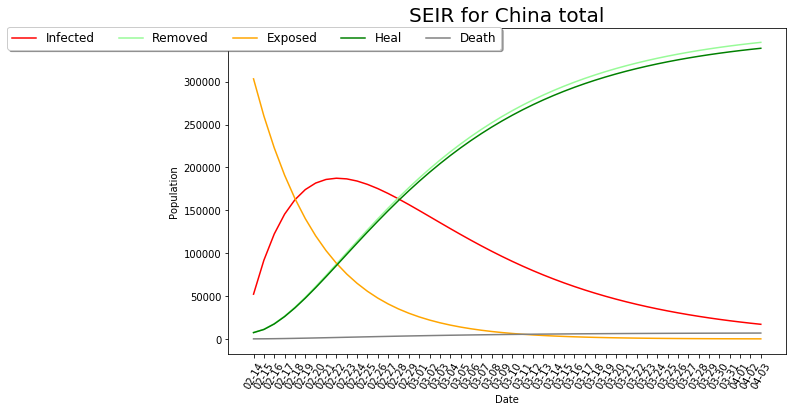

In [120]:
result = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=China_population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for China total', death_rate=0.02, show_Sus = False,\
                  starting_point = China_total['Date'].max()+datetime.timedelta(days=1))
result['Date'] = list((China_total['Date'].min() + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(50))

The MAPE is: 
0.25434740727747207


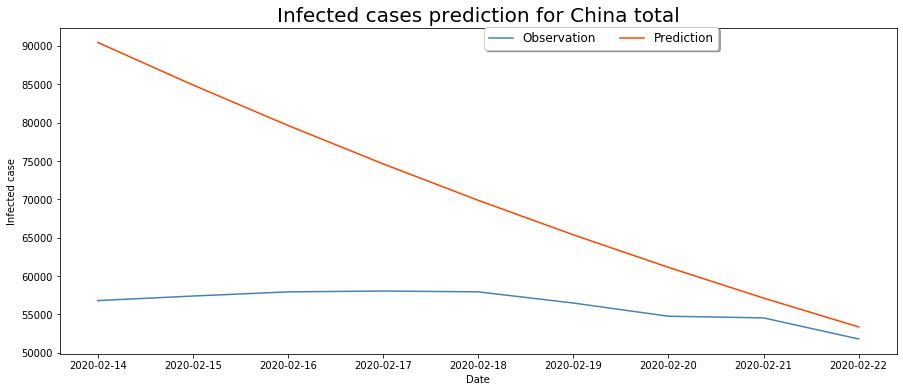

In [121]:
"""
Calculate MAPE test score using SEIR model result
"""
test = SIR_data[SIR_data['Date'] >= datetime.datetime(2020, 2, 14)]
test = test[test['Country']=='China'].groupby('Date').agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()
plot_test_data_with_MAPE(test, result, 'Infected cases prediction for China total')

### Estimate China, Ex-Hubei

Maximum infected case:  13529


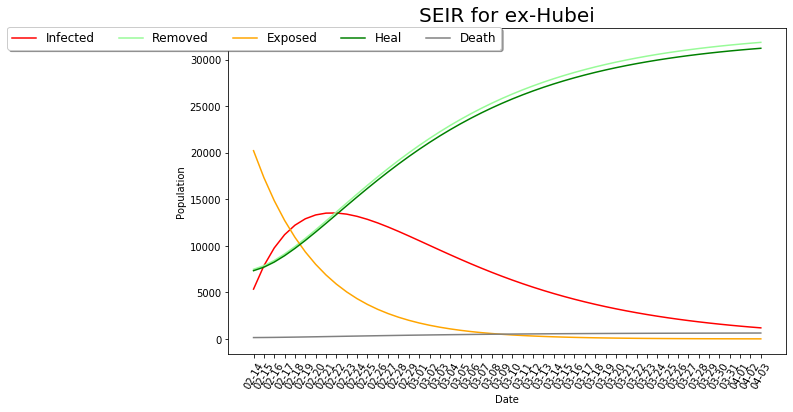

The MAPE is: 
0.31176200714016156


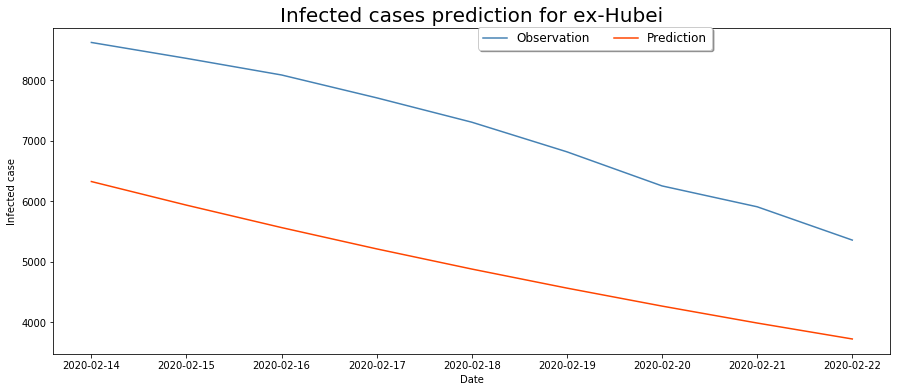

In [122]:
NotHubei = df[(df['Country']=='China')&(df['Province']!='Hubei')].groupby('Date')\
            .agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()

nothubei_dxy = get_China_exclude_province(China_dxy,"Hubei Province")
                                       
population = China_population - Hubei_population
est_beta = 402/population # based on MCMC result

## use the last observation as the initial point in the new SEIR model
I0 = list(NotHubei['I'])[-1]
R0 = list(NotHubei['R'])[-1]
E0 = nothubei_dxy['E'].iloc[-1]*2
S0 = population - I0 - E0 - R0

result2 = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for ex-Hubei', death_rate=0.02, show_Sus = False,\
                  starting_point = NotHubei['Date'].max()+datetime.timedelta(days=1))

result2['Date'] = list((NotHubei['Date'].min() + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(50))

"""
Calculate MAPE test score using SEIR model result
"""
test = SIR_data[SIR_data['Date'] >= datetime.datetime(2020, 2, 14)] 
test = test[(test['Country']=='China')&(test['Province']!='Hubei')].groupby('Date').agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()
plot_test_data_with_MAPE(test, result2, 'Infected cases prediction for ex-Hubei')

## Estimate Hubei 
Which is equal China total - Ex-Hubei


Maximum infected case:  46439


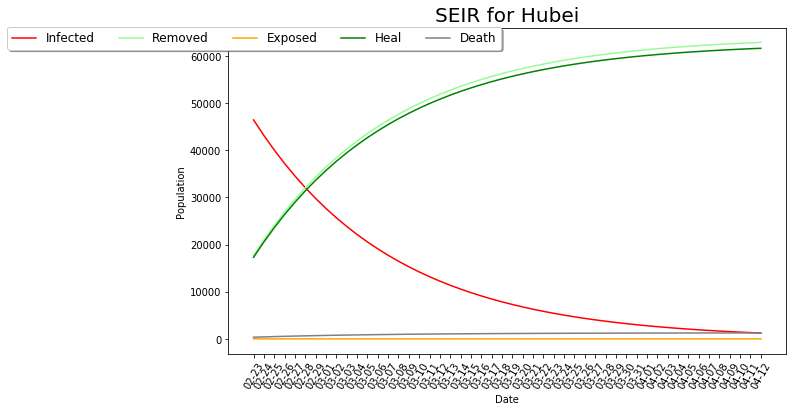

The MAPE is: 
0.8875575333913016


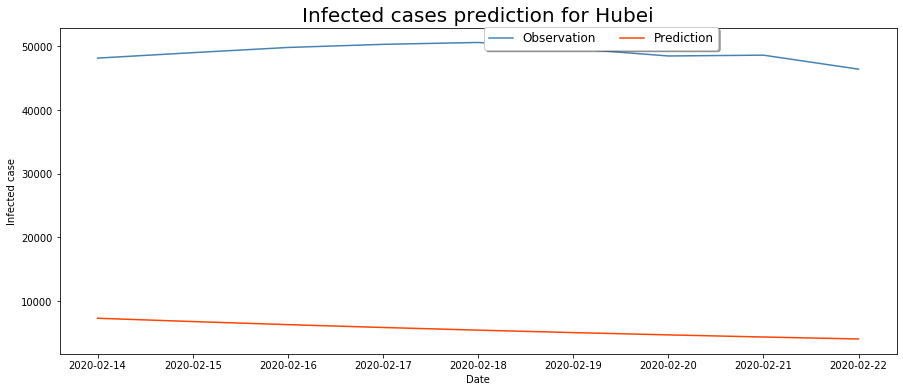

In [124]:
## data process
# Hubei = get_province_df(China_df, "Hubei Province")
# # del Hubei['E']
# Hubei  = pd.merge(Hubei, NotHubei[['date','E']], on='date')
# Hubei["E"] = NotHubei["E"] * 3/4 # suppose the number of exposed cases inside Hubei

# ## estimted result 
# result_Hubei = result - result2

# China_df_test = SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)] 
# test = get_province_df(China_df_test, "Hubei Province")

# plot_test_data_with_MAPE(test, result_Hubei,'Infected cases prediction for Hubei')



Hubei = df[(df['Country']=='China')&(df['Province']=='Hubei')].groupby('Date')\
            .agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()

hubei_dxy = get_province_df(China_dxy,"Hubei Province")
                                       
population = Hubei_population
est_beta = 1457.2/population # based on MCMC result

## use the last observation as the initial point in the new SEIR model
I0 = list(Hubei['I'])[-1]
R0 = list(Hubei['R'])[-1]
E0 = hubei_dxy['E'].iloc[-1]*10
S0 = population - I0 - E0 - R0

result2 = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for Hubei', death_rate=0.02, show_Sus = False,\
                  starting_point = Hubei['Date'].max()+datetime.timedelta(days=1))

result2['Date'] = list((NotHubei['Date'].min() + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(50))

"""
Calculate MAPE test score using SEIR model result
"""
test = SIR_data[SIR_data['Date'] >= datetime.datetime(2020, 2, 14)] 
test = test[(test['Country']=='China')&(test['Province']=='Hubei')].groupby('Date').agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()
plot_test_data_with_MAPE(test, result2, 'Infected cases prediction for Hubei')

### Estimate Ex-China
Use JHU dataset

In [11]:
world_population = 7000000000 - China_population # assumption
population = world_population
est_beta = 47/population # based on MCMC result

Maximum infected case:  453


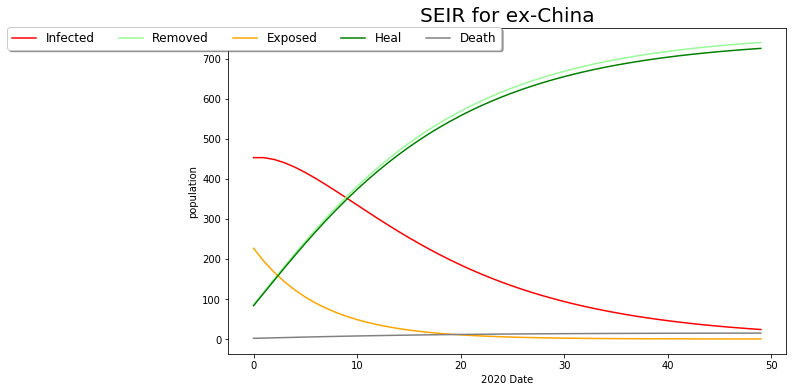

The MAMPE is: 
0.4581675751525594


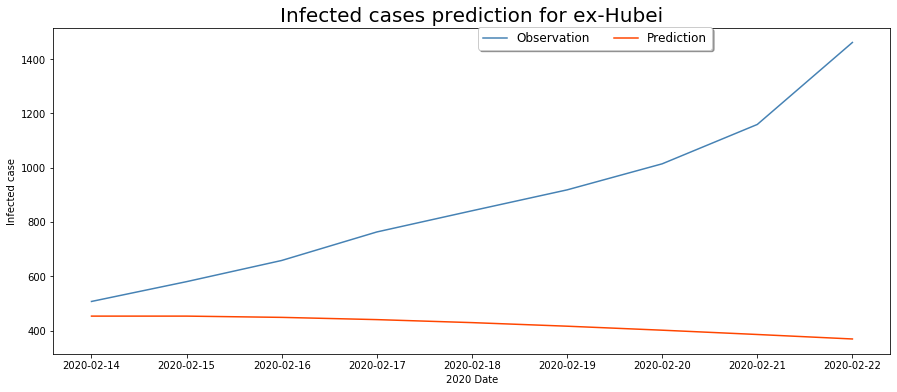

In [12]:
## Load data 
df = pd.read_csv("../data/daily_time_series_data_JHU.csv").rename(columns={"Date": "date"})

"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

first_day = datetime.datetime(2019, 12, 8) # the time when detected the first case (2019-12-08)
df['Days'] = (df['date'] - first_day).dt.days

## Dataset preperation
df['R'] = df['Deaths'] + df['Recovered']
df["I"] = df['Confirmed'] - df['R'] # net confirmed case
SIR_data = df[['date', 'Days','Country','Province','I','R']]
Sum_country = SIR_data.groupby(['Country','date','Days'])['I', 'R'].sum().reset_index()

NotChina_df = SIR_data[SIR_data['Country'] != 'China']
NotChina_df = NotChina_df.groupby(['date','Days'])['I', 'R'].sum().reset_index()
# ex-China total
# Use data before 2020-02-14 for train model
NotChina = NotChina_df[NotChina_df['date'] < datetime.datetime(2020, 2, 14)] 


"""
parameter for SEIR model
"""
## use the last observation as the initial point in the new SEIR model
I0 = list(NotChina['I'])[-1]
R0 = list(NotChina['R'])[-1]
E0 = list(NotChina['I'])[-1] * 1/2 # suppose the number of exposed cases outside China
S0 = population - I0 - E0 - R0

result3 = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for ex-China', death_rate=0.02, show_Sus = False)

"""
Calculate MAPE test score using SEIR model result
"""
test = NotChina_df[NotChina_df['date'] >= datetime.datetime(2020, 2, 14)] 
plot_test_data_with_MAPE(test, result3, 'Infected cases prediction for ex-Hubei')

In [24]:
N = 20000   # Total population as an arbituary number, putting it as the size of Singapore's population
I0, R0 = 144, 0 # Initial number of Infected (base on first case of Wuhan infection) and Recovered cases
E0 = 1440 # initial number of Exposed cases based on CNA (https://www.channelnewsasia.com/news/singapore/wuhan-virus-singapore-what-we-know-confirmed-cases-12324270)
S0 = N - E0 - I0 - R0 # initial susceptible population

incubation_duration = 4 # based on paper (which is based on SARS's incubation period)
serial_interval = 6
infectious_duration = serial_interval - incubation_duration 

sigma = 1/incubation_duration # incubation rate
gamma = 1/infectious_duration # recovery rate
beta = 1867.1/N

n_days = 50

def deriv(y, t, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E 
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [25]:
from scipy.integrate import odeint

# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SEIR equations over the time grid, t.
t = np.linspace(0, n_days, n_days)

ret = odeint(deriv, y0, t, args=(N, beta, sigma, gamma))
S, E, I, R = ret.T


In [26]:
from datetime import datetime
date_start = datetime.strptime('2020-01-24', '%Y-%m-%d')
datelist = pd.date_range(date_start,periods=n_days).to_list()
dates = [str(d.date()) for d in datelist]

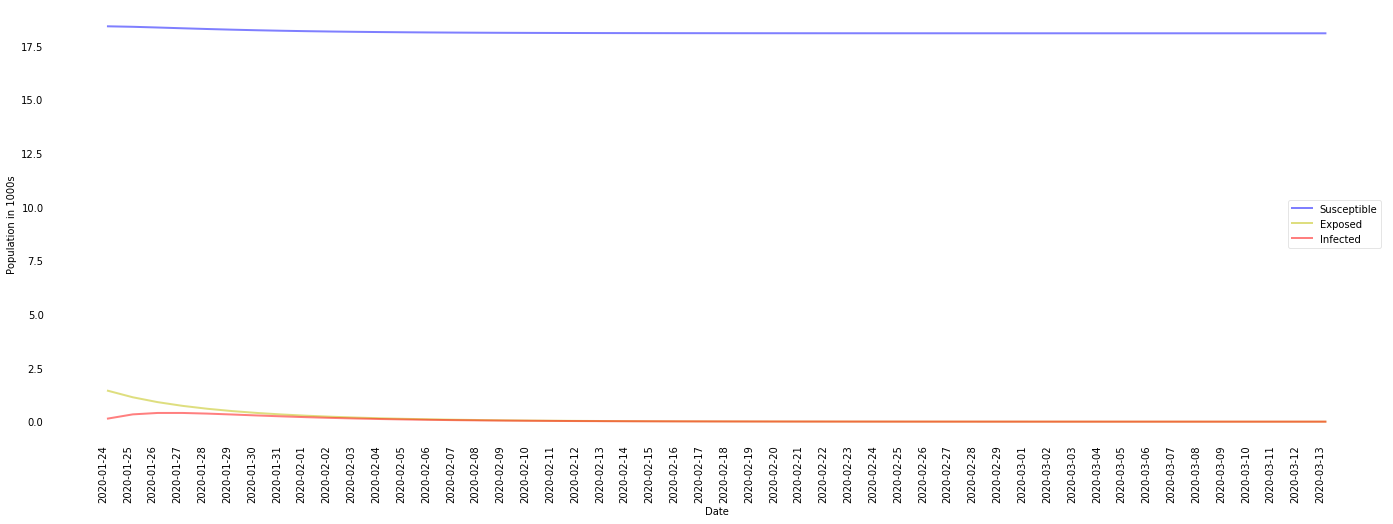

In [28]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot()
ax.plot(dates, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(dates, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(dates, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
# ax.plot(dates, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

ax.set_xticks(range(n_days),2)
ax.set_xticklabels([str(d.date()) for d in datelist], rotation = 90, ha="right")
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('Date')
ax.set_ylabel(f'Population in {1000}s')
# ax.set_ylim(0,1.2*N/1000)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()